# **Andrej Karpathy Micrograd Tutorial**
## [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&t=969s)

___

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

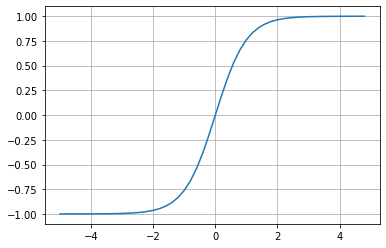

In [2]:
"""
neuron:
output = activation_fn(sum(weights * inputs) + bias)

lets try tanh as the activation_fn
"""

plt.plot(
    np.arange(-5,5,0.2),
    np.tanh(np.arange(-5,5,0.2))
)
plt.grid()

In [3]:
from graphviz import Digraph

def trace(root):
    # builds set of all nodes and edges in graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # LR: left -> right
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # for value - create rectangular 'record' node
        dot.node(name=uid, 
                 label = f"{n.label} | data: {n.data:.4f} | grad: {n.grad:.4f}", 
                 shape='record'
                )
        
        # if result of an operation, create operator node
        if n._op:
            dot.node(name=uid+n._op, label = n._op)
            dot.edge(uid+n._op, uid)

    for n1,n2 in edges:
        # connect n1 -> op node of n2
        dot.edge(str(id(n1)), str(id(n2))+n2._op)

    return dot

In [4]:
class Value:
    
    def __init__(self,data, _children = (), _op='', label=''):
        self.data = data
        self.grad = 0.0 # 0 = no effect
        self._prev = set(_children)
        self._op = _op
        self.label = label

    
    def __repr__(self):
        return f"Value(data={self.data})"

    # addition: internally a.__add__(b)
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')

    # multiplication
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

    # activate with tanh
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(t, (self, ), 'tanh')
        return out

In [5]:
# 2D input:

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights for each input
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813, label='b')

# output
x1w1 = x1*w1
x1w1.label = 'x1*w1'

x2w2 = x2*w2
x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1+x2w2
x1w1x2w2.label = 'x1w1+x2w2'

n = x1w1x2w2 + b
n.label = 'n'

o = n.tanh()
o.label = 'output'

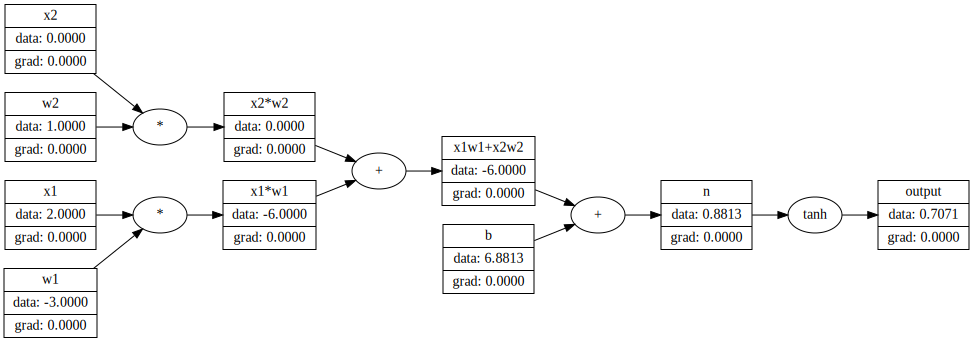

In [6]:
draw_dot(o)

# Manual Backpropagation

In [7]:
o.grad = 1.0

```
o = tanh(o)
d(tanh(x))/dx = 1 - (tanh(x))**2

do/dn = 1 - (tanh(n))**2
      = 1 - o**2
```

In [8]:
n.grad = 1 - o.data ** 2

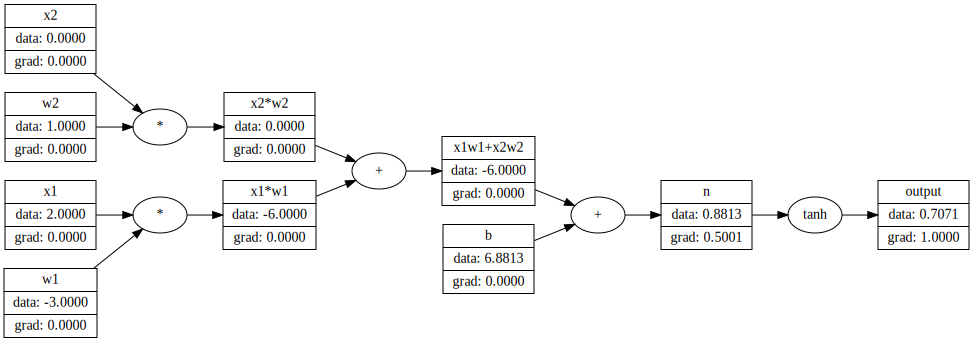

In [9]:
draw_dot(o)

```
n = x1w1+x2w2 + b
d(n)/d(x1w1+x2w2) = 1
d(n)/d(b) = 1 

do/d(x1w1+x2w2) = do/dn * d(n)/d(x1w1+x2w2)
                = do/dn * 1
                = do/dn

do/db = do/dn * dn/db
      = do/dn * 1
      = do/dn
```

In [10]:
x1w1x2w2.grad = n.grad
b.grad = n.grad

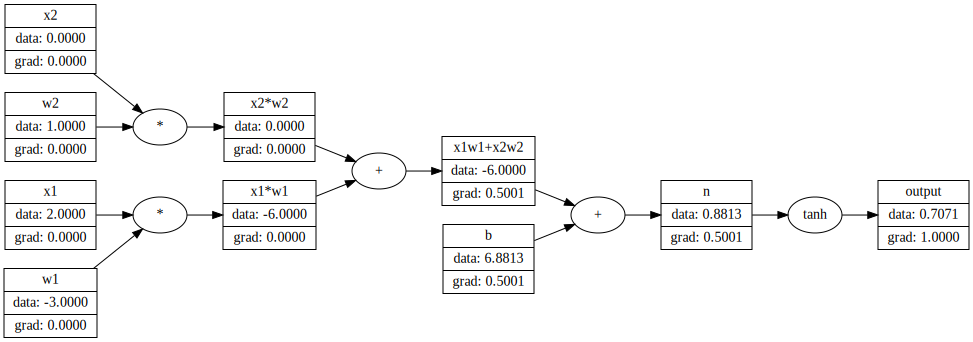

In [12]:
draw_dot(o)

```
x1w1x2w2 = x1w1 + x2w2
d(x1w1x2w2)/d(x1w1) = 1
d(x1w1x2w2)/d(x2w2) = 1

do/d(x1w1) = do/d(x1w1x2w2) * d(x1w1x2w2)/d(x1w1)
           = do/d(x1w1x2w2)

do/d(x2w2) = do/d(x1w1x2w2) * d(x1w1x2w2)/d(x2w2)
           = do/d(x1w1x2w2)

```

In [13]:
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

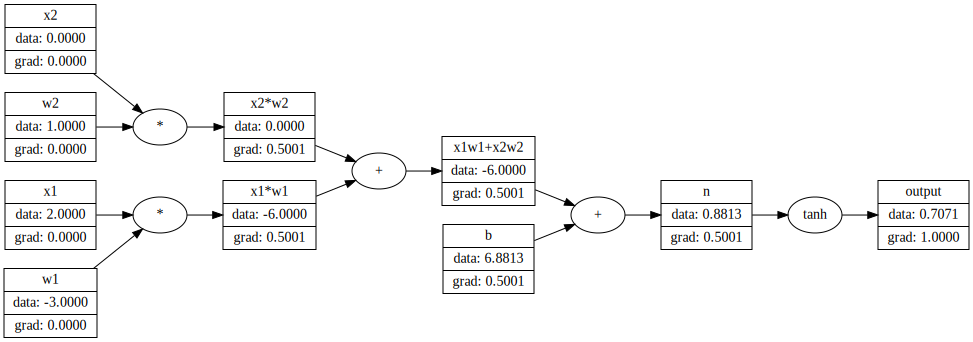

In [14]:
draw_dot(o)

```
x2w2 = x2*w2
d(x2w2)/d(x2) = w2
d(x2w2)/d(w2) = x2
 
do/d(x2) = do/d(x2w2) * d(x2w2)/d(x2)
         = do/d(x2w2) * w2

do/d(w2) = do/d(x2w2) * d(x2w2)/d(w2)
         = do/d(x2w2) * x2

-----------------

x1w1 = x1*w1
d(x1w1)/d(x1) = w1
d(x1w1)/d(w1) = x1
 
do/d(x1) = do/d(x1w1) * d(x1w1)/d(x1)
         = do/d(x1w1) * w1

do/d(w1) = do/d(x1w1) * d(x1w1)/d(w1)
         = do/d(x1w1) * x1

```

In [15]:
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

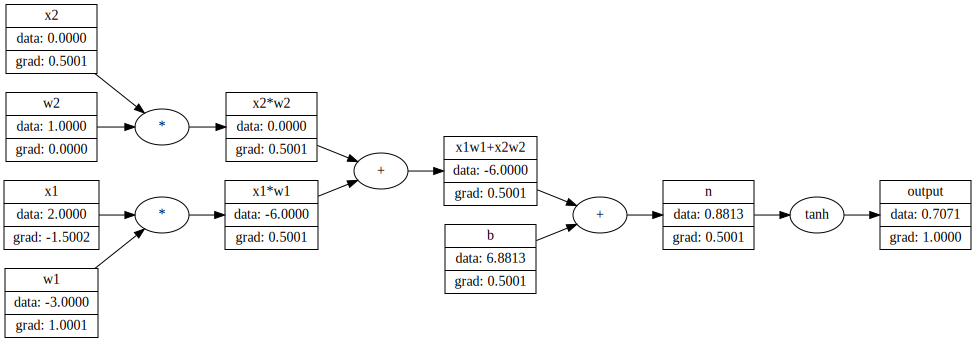

In [16]:
draw_dot(o)

# Semi-Automatic Backpropagation
we call the backward method manually

In [36]:
class Value:
    
    def __init__(self,data, _children = (), _op='', label=''):
        self.data = data
        
        self.grad = 0.0
        # function which will backpropagate
        # based on chain rule
        self._backward = lambda : None
        
        self._prev = set(_children)
        self._op = _op
        self.label = label

    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

        out._backward = _backward

        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad

        out._backward = _backward

        return out

In [37]:
# redefining out neuron

# 2D input:

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights for each input
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813, label='b')

# output
x1w1 = x1*w1
x1w1.label = 'x1*w1'

x2w2 = x2*w2
x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1+x2w2
x1w1x2w2.label = 'x1w1+x2w2'

n = x1w1x2w2 + b
n.label = 'n'

o = n.tanh()
o.label = 'output'

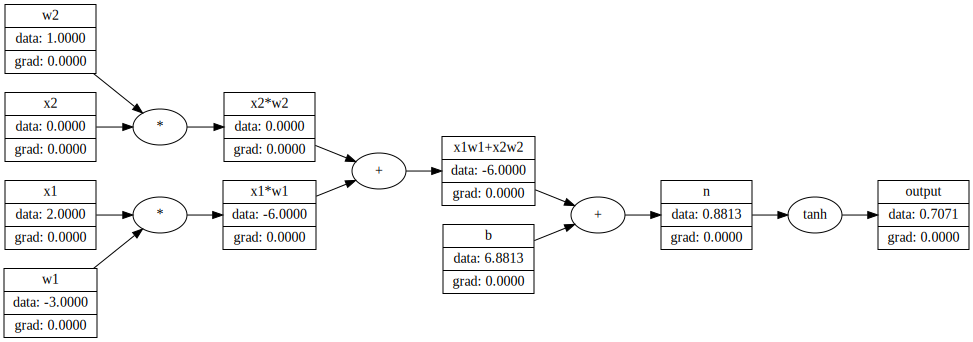

In [38]:
draw_dot(o)

In [39]:
# we'll set the output grad to 1.0 as the base case
# then we'll call the _backward method for each node in the correct order
# which will propagate the gradient

o.grad = 1.0

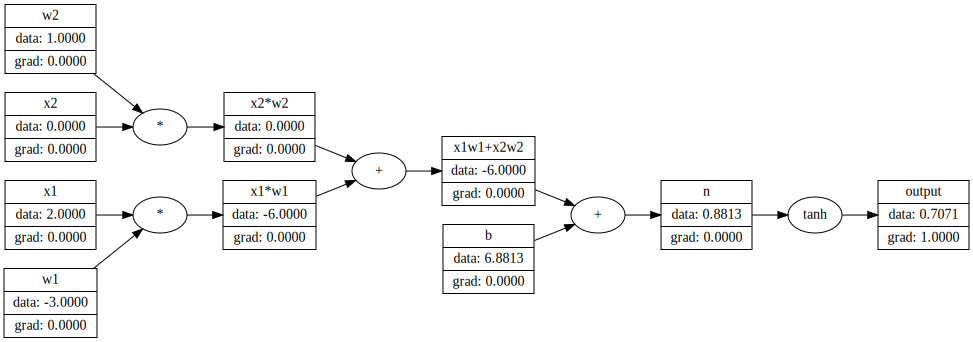

In [40]:
draw_dot(o)

In [41]:
o._backward()

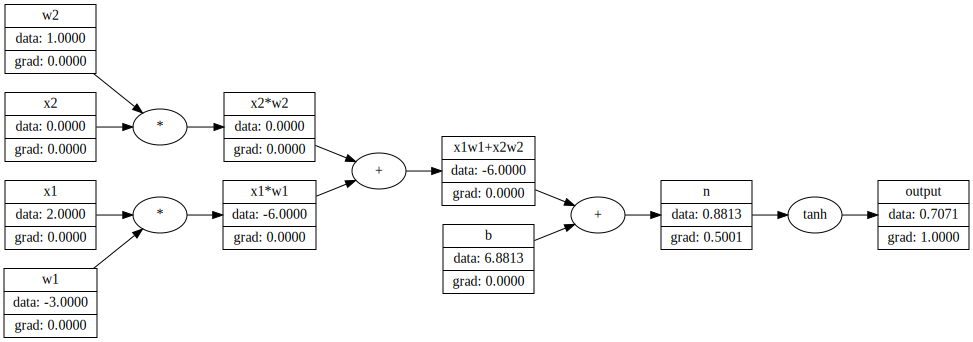

In [42]:
draw_dot(o)

In [43]:
n._backward()

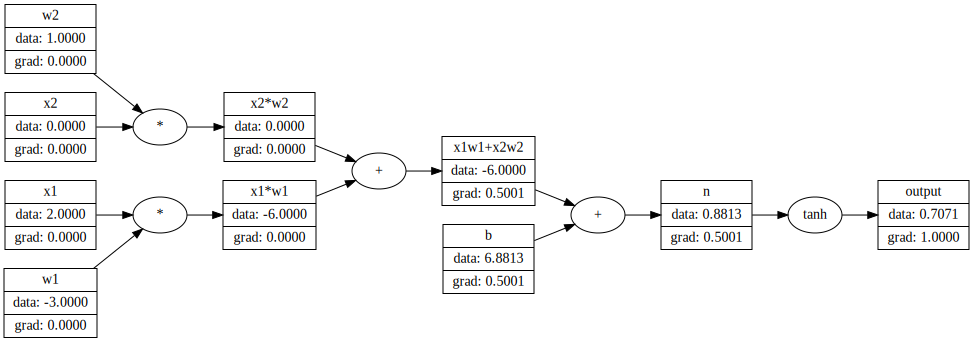

In [44]:
draw_dot(o)

In [45]:
b._backward() # does nothing since it's a leaf node
x1w1x2w2._backward()

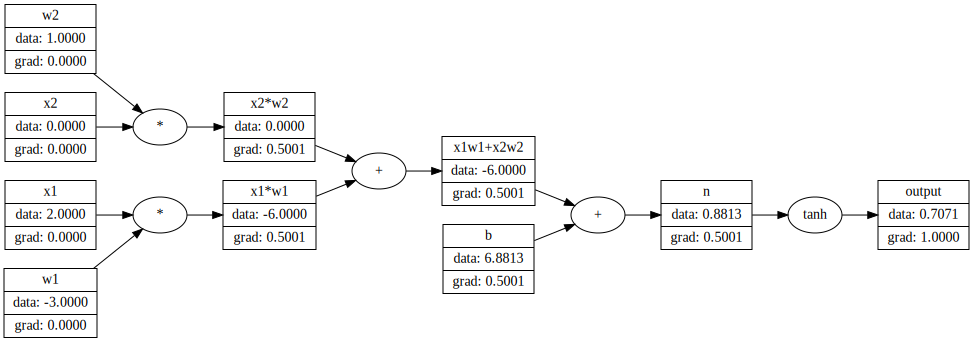

In [46]:
draw_dot(o)

In [47]:
x1w1._backward()
x2w2._backward()

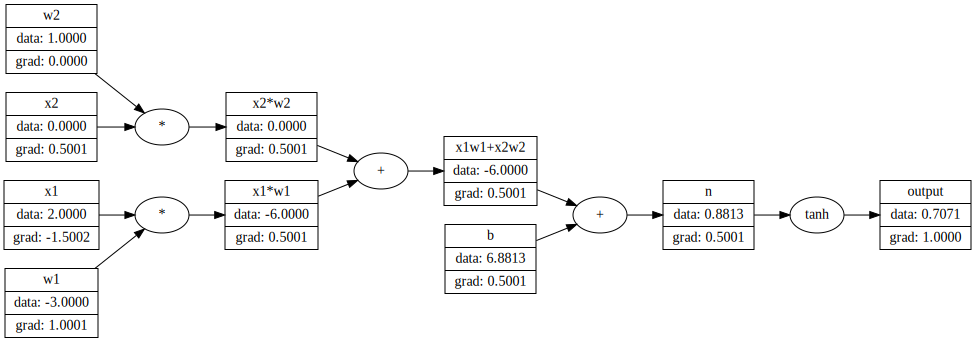

In [48]:
draw_dot(o) # compare with output of cell 16 -- it works! :)

___